# Lesson 09 - Flow over a cylinder with Source Panels 

We have used flow singularities to represent simple gemometries (Rankine Oval) or circular cylinder immersed in a freestream 

What isf we want to represent an arbitrary geometry? We will learn that in this lesson. This method consists of representing geometry of a body by a series of linear segments or panels that correspond to source sheets 



In [2]:
import math
import numpy 
from scipy import integrate 
from matplotlib import pyplot
# embed those figures 
%matplotlib inline 

In [3]:
u_inf = 1.0 #freestream 


## Defing the geometry 

We want a circular cylinder of unit radius 

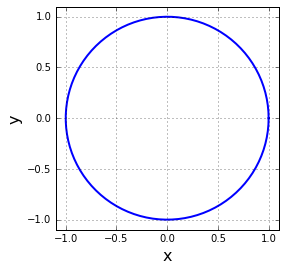

In [4]:
#define the cylinder 
R = 1.0 
theta = numpy.linspace(0, 2*math.pi, 100)
x_cylinder, y_cylinder = R*numpy.cos(theta), R*numpy.sin(theta)

#plot the cylinder 
size =4
pyplot.figure(figsize = (size,size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize =16)
pyplot.plot(x_cylinder, y_cylinder, color = 'b', linestyle = '-', linewidth = 2)
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

## Discretization into panels 

A panel is represented by the two end points (xa, ya) and (xb, yb) and its strength sigma. The orientaton is defined by angle between the x-axis and the normal in a counter-clockwise sense 

In [9]:
class Panel: 
    """
    contains info related to a panel 
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initialized the panel 
        
        Sets the end-points and calculated the center, length, and angle 
        (with the x-axis) of the panel 
        Initializes the strength of the source-sheet, the tangential velocity, 
        and the pressure coefficient to zeo
        
        Parameters
        _----------
        xa (float): x-coordinate of the first end-point 
        ya (float): y-coordinate of the first end point 
        xb (float): x-coordinate of the second end-point 
        yb (float): y-coordinate of the second end point 
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.       
        
        

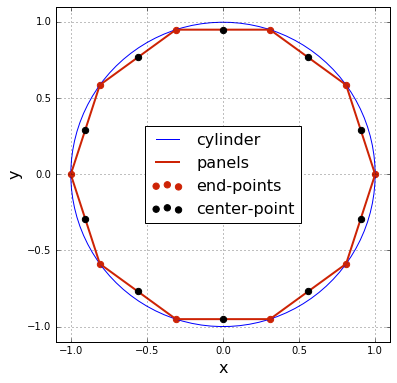

In [11]:
N_panels =10  # number of panels desired 

#define the end points of the panels 
x_ends = R*numpy.cos(numpy.linspace(0,2*math.pi, N_panels+1))
y_ends = R*numpy.sin(numpy.linspace(0, 2*math.pi, N_panels+1))

#define the panels 
panels = numpy.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])

# plot the panels 
size = 6 
pyplot.figure(figsize=(size,size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize = 16)
pyplot.plot(x_cylinder, y_cylinder, label='cylinder', color = 'b', linestyle = '-', 
           linewidth = 1)
pyplot.plot(x_ends, y_ends, label= 'panels', color = '#CD2305', 
           linestyle = '-', linewidth =2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels], 
              label = 'end-points', color = '#CD2305', s= 40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], 
              label = 'center-point', color = 'k', s=40, zorder =3)
pyplot.legend(loc='best', prop = {'size':16})
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

## Flow-tangency boundary condition 


In [13]:
def integral_normal(p_i, p_j): 
    """
    Evaluates the contributions of a panels at the center-point of another, 
    in the normal direction.
    
    Parameters
    ----------
    p_i: Panel object 
        Panel on which the contribution is calculated.
    p_j: panel object 
        Panel from the contribution is calculated 
        
    Returns
    --------
    Integral over the panel at the center point of the other. 
    """
    
    def integrand(s): 
        return ( (+(p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.cos(p_i.beta)
                 +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.sin(p_i.beta))
                /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2
                 +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2) )
    return integrate.quad(integrand,0.0, p_j.length)[0]
